In [1]:
!pip -q install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 req

In [2]:
import os, json, math, random, csv, datetime
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold

In [3]:
DATASET_DIR = "/kaggle/input/iwilldoit/dataset_clean-20251129T040838Z-1-001/dataset_clean"
SAVE_DIR = "/kaggle/working"

assert os.path.exists(DATASET_DIR), f"❌ Dataset tidak ditemukan: {DATASET_DIR}"

# Create run directory with timestamp
RUN_ID = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(SAVE_DIR, f"run_fewshot_{RUN_ID}")
os.makedirs(RUN_DIR, exist_ok=True)

METRIC_CSV = os.path.join(RUN_DIR, "metrics.csv")
MODEL_SAVE_PATH = os.path.join(RUN_DIR, "best_model.pth")
CONFMAT_PATH = os.path.join(RUN_DIR, "confusion_matrix.png")
REPORT_PATH = os.path.join(RUN_DIR, "classification_report.txt")
PLOT_PATH = os.path.join(RUN_DIR, "training_curves.png")


print(" RUN DIRECTORY:", RUN_DIR)
print(" DATASET DIR:", DATASET_DIR)


 RUN DIRECTORY: /kaggle/working/run_fewshot_20251201_133258
 DATASET DIR: /kaggle/input/iwilldoit/dataset_clean-20251129T040838Z-1-001/dataset_clean


In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Model & Training
IMG_SIZE = 224
BATCH_SIZE = 16              # Kecil untuk stabilitas
EMBED_DIM = 256              # Lebih kecil dari 512
DROPOUT = 0.6                # Tinggi untuk regularisasi
EPOCHS = 120                 # Cukup panjang
PATIENCE = 12                # Early stopping

# Learning Rates
BACKBONE_LR = 3e-5           # Sangat kecil untuk pretrained weights
HEAD_LR = 3e-4               # Lebih besar untuk classifier
WEIGHT_DECAY = 5e-4          # Regularisasi kuat

# ArcFace
ARC_SCALE = 64.0
ARC_MARGIN_MIN = 0.35
ARC_MARGIN_MAX = 0.65

# Augmentation
EPOCH_SAMPLES_FACTOR = 50    # 50x oversampling per epoch
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0
MIXUP_PROB = 0.3             # 30% mixup
CUTMIX_PROB = 0.3            # 30% cutmix

# Scheduler
WARMUP_EPOCHS = 5
EMA_DECAY = 0.9997

# Loss
FOCAL_GAMMA = 2.0
FOCAL_ALPHA = 0.25

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f" DEVICE: {DEVICE}")
print(f" STRATEGY: Extreme Few-Shot (4 img/class)")


 DEVICE: cuda
 STRATEGY: Extreme Few-Shot (4 img/class)


In [5]:
all_samples = []
for person_dir in Path(DATASET_DIR).iterdir():
    if not person_dir.is_dir():
        continue
    label = person_dir.name
    for img_path in person_dir.iterdir():
        if img_path.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            all_samples.append((str(img_path), label))

df = pd.DataFrame(all_samples, columns=["filepath", "label"])
df = df.dropna().reset_index(drop=True)

print(f" Total images: {len(df)}")
print(f" Total classes: {df['label'].nunique()}")
print(f" Avg images/class: {len(df) / df['label'].nunique():.1f}")

# Split: 1 gambar per kelas untuk validasi
val_idx = []
for name, grp in df.groupby("label", sort=False):
    if len(grp) >= 2:  # Skip kelas dengan hanya 1 gambar
        val_idx.extend(grp.sample(n=1, random_state=SEED).index.tolist())

val_df = df.loc[val_idx].reset_index(drop=True)
train_df = df.drop(index=val_idx).reset_index(drop=True)

# Create class mappings
classes = sorted(train_df["label"].unique().tolist())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
NUM_CLASSES = len(classes)

# Filter validation set
val_df = val_df[val_df["label"].isin(classes)].reset_index(drop=True)

print(f"\n Data Split:")
print(f"   Train: {len(train_df)} samples")
print(f"   Val:   {len(val_df)} samples")
print(f"   Classes: {NUM_CLASSES}")

# Class distribution
class_counts = train_df['label'].value_counts()
print(f"\n Class Distribution:")
print(f"   Min samples/class: {class_counts.min()}")
print(f"   Max samples/class: {class_counts.max()}")
print(f"   Mean samples/class: {class_counts.mean():.1f}")

assert len(train_df) > 0, " No training data!"
assert len(val_df) > 0, " No validation data!"
assert set(val_df["label"].unique()).issubset(set(classes)), " Val has unknown classes!"

 Total images: 278
 Total classes: 70
 Avg images/class: 4.0

 Data Split:
   Train: 208 samples
   Val:   70 samples
   Classes: 70

 Class Distribution:
   Min samples/class: 2
   Max samples/class: 3
   Mean samples/class: 3.0


In [6]:
class ExtremeFaceAugmentation:
    """Augmentasi super agresif untuk few-shot learning"""
    
    def __init__(self, img_size=224):
        self.img_size = img_size
        
        # Base transforms
        self.base = T.Compose([
            T.RandomResizedCrop(
                img_size,
                scale=(0.70, 1.0),
                ratio=(0.85, 1.15),
                interpolation=InterpolationMode.BILINEAR
            ),
            T.RandomHorizontalFlip(p=0.5),
        ])
        
        # Geometric augmentations
        self.geometric = T.RandomApply([
            T.RandomChoice([
                T.RandomAffine(
                    degrees=20,
                    translate=(0.1, 0.1),
                    scale=(0.85, 1.15),
                    shear=10
                ),
                T.RandomPerspective(distortion_scale=0.3, p=1.0),
                T.RandomRotation(degrees=25),
            ])
        ], p=0.8)
        
        # Color augmentations
        self.color = T.RandomApply([
            T.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.3,
                hue=0.05
            )
        ], p=0.9)
        
        # Lighting
        self.lighting = T.RandomChoice([
            T.RandomAutocontrast(p=1.0),
            T.RandomAdjustSharpness(sharpness_factor=2, p=1.0),
            T.Lambda(lambda x: x),
        ])
        
        # Normalize
        self.normalize = T.Normalize([0.5]*3, [0.5]*3)
        
        # Occlusion
        self.occlusion = T.RandomErasing(
            p=0.5,
            scale=(0.02, 0.25),
            ratio=(0.3, 3.3),
            value='random'
        )
    
    def __call__(self, img):
        img = self.base(img)
        img = self.geometric(img)
        img = self.color(img)
        
        # Convert to tensor
        img = T.ToTensor()(img)
        
        # Apply lighting
        if torch.rand(1) < 0.5:
            img = self.lighting(img)
        
        # Normalize
        img = self.normalize(img)
        
        # Add noise
        if torch.rand(1) < 0.3:
            img = img + torch.randn_like(img) * 0.03
            img = torch.clamp(img, -1, 1)
        
        # Occlusion
        img = self.occlusion(img)
        
        return img

train_tfms = ExtremeFaceAugmentation(img_size=IMG_SIZE)

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])



In [7]:
class FaceDataset(Dataset):
    def __init__(self, df, transform, class_to_idx):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filepath = self.df.iloc[idx]["filepath"]
        label = self.df.iloc[idx]["label"]
        
        img = Image.open(filepath).convert("RGB")
        img = self.transform(img)
        
        return img, self.class_to_idx[label]

train_set = FaceDataset(train_df, train_tfms, class_to_idx)
val_set = FaceDataset(val_df, val_tfms, class_to_idx)

# Weighted sampler untuk balance classes
counts = Counter([class_to_idx[l] for l in train_df["label"]])
weights = [1.0 / max(counts[class_to_idx[l]], 1) for l in train_df["label"]]
num_samples = len(weights) * EPOCH_SAMPLES_FACTOR

sampler = WeightedRandomSampler(
    weights,
    num_samples=num_samples,
    replacement=True
)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f" Train batches/epoch: {len(train_loader)}")
print(f" Val batches: {len(val_loader)}")
print(f" Samples/epoch: ~{num_samples}")

 Train batches/epoch: 650
 Val batches: 5
 Samples/epoch: ~10400


In [8]:
from torchvision.models import resnet34, ResNet34_Weights

class ResNet34Embedding(nn.Module):
    """ResNet34 untuk few-shot (lebih kecil dari ResNet50)"""
    
    def __init__(self, embed_dim=256, p_drop=0.6):
        super().__init__()
        
        # Load pretrained ResNet34
        backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        
        self.backbone = backbone
        self.bn = nn.BatchNorm1d(in_features)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(in_features, embed_dim)
        
        # Initialize fc layer
        nn.init.normal_(self.fc.weight, std=0.01)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        features = self.backbone(x)
        features = self.bn(features)
        features = self.dropout(features)
        embeddings = self.fc(features)
        return embeddings

model = ResNet34Embedding(
    embed_dim=EMBED_DIM,
    p_drop=DROPOUT
).to(DEVICE)

print(f" Model: ResNet34 → {EMBED_DIM}D embeddings")
print(f" Dropout: {DROPOUT}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 204MB/s]


 Model: ResNet34 → 256D embeddings
 Dropout: 0.6


In [9]:
class ArcMarginProduct(nn.Module):
    """ArcFace with dynamic margin"""
    
    def __init__(self, in_features, out_features, s=64.0, m=0.35):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = float(s)
        self.m = float(m)
        
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m
    
    def update_margin(self, m):
        """Update margin dynamically"""
        self.m = float(m)
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m
    
    def forward(self, embeddings, labels):
        # Normalize
        embeddings = F.normalize(embeddings)
        W = F.normalize(self.weight)
        
        # Cosine similarity
        cos_theta = F.linear(embeddings, W)
        sin_theta = torch.sqrt(torch.clamp(1.0 - cos_theta * cos_theta, min=1e-7))
        
        # Add margin
        phi = cos_theta * self.cos_m - sin_theta * self.sin_m
        phi = torch.where(cos_theta > self.th, phi, cos_theta - self.mm)
        
        # One-hot encoding
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)
        
        # Combine
        output = (one_hot * phi + (1.0 - one_hot) * cos_theta) * self.s
        
        return output

arc = ArcMarginProduct(
    in_features=EMBED_DIM,
    out_features=NUM_CLASSES,
    s=ARC_SCALE,
    m=ARC_MARGIN_MIN
).to(DEVICE)

print(f" ArcFace: s={ARC_SCALE}, m={ARC_MARGIN_MIN}→{ARC_MARGIN_MAX}")

 ArcFace: s=64.0, m=0.35→0.65


In [10]:
class FocalLoss(nn.Module):
    """Focal Loss untuk handle hard examples"""
    
    def __init__(self, gamma=2.0, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)

print(f" Loss: Focal (γ={FOCAL_GAMMA}, α={FOCAL_ALPHA})")

 Loss: Focal (γ=2.0, α=0.25)


In [11]:
optimizer = optim.AdamW([
    {"params": model.backbone.parameters(), "lr": BACKBONE_LR, "weight_decay": WEIGHT_DECAY},
    {"params": model.bn.parameters(), "lr": BACKBONE_LR, "weight_decay": WEIGHT_DECAY},
    {"params": model.fc.parameters(), "lr": HEAD_LR, "weight_decay": WEIGHT_DECAY},
    {"params": arc.parameters(), "lr": HEAD_LR, "weight_decay": WEIGHT_DECAY},
])

# Warmup + Cosine scheduler
scheduler_warmup = optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=0.1,
    total_iters=WARMUP_EPOCHS
)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=max(EPOCHS - WARMUP_EPOCHS, 1),
    eta_min=1e-6
)

def step_scheduler(epoch):
    if epoch <= WARMUP_EPOCHS:
        scheduler_warmup.step()
    else:
        if epoch == WARMUP_EPOCHS + 1:
            scheduler_cosine.last_epoch = -1
        scheduler_cosine.step()

print(f" Optimizer: AdamW (backbone={BACKBONE_LR}, head={HEAD_LR})")
print(f" Scheduler: Warmup({WARMUP_EPOCHS}) + Cosine")

 Optimizer: AdamW (backbone=3e-05, head=0.0003)
 Scheduler: Warmup(5) + Cosine


In [12]:
class EMA:
    """Exponential Moving Average of model weights"""
    
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.detach().clone()
    
    @torch.no_grad()
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name].mul_(self.decay).add_(
                    param.detach(), alpha=1 - self.decay
                )
    
    @torch.no_grad()
    def apply_to(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.detach().clone()
                param.data.copy_(self.shadow[name])
    
    @torch.no_grad()
    def restore(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.backup[name])

ema = EMA(model, decay=EMA_DECAY)

print(f" EMA: decay={EMA_DECAY}")

 EMA: decay=0.9997


In [13]:
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    """CutMix augmentation"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    
    _, _, H, W = x.shape
    cut_ratio = np.sqrt(1.0 - lam)
    cut_h = int(H * cut_ratio)
    cut_w = int(W * cut_ratio)
    
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    
    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    y_a, y_b = y, y[index]
    
    return x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixed loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print(f" Augmentation: Mixup(α={MIXUP_ALPHA}) + CutMix(α={CUTMIX_ALPHA})")

 Augmentation: Mixup(α=0.2) + CutMix(α=1.0)


In [14]:
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

def train_one_epoch(epoch):
    """Train for one epoch"""
    model.train()
    arc.train()
    
    total_loss = 0.0
    total_samples = 0
    correct = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        
        # Random augmentation strategy
        r = np.random.rand()
        
        with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
            if epoch <= WARMUP_EPOCHS:
                # Warmup: no mixup/cutmix
                embeddings = model(x)
                cos_logits = F.linear(
                    F.normalize(embeddings),
                    F.normalize(arc.weight)
                ) * ARC_SCALE
                loss = criterion(cos_logits, y)
                pred = cos_logits.argmax(1)
                
            else:
                # Apply mixup/cutmix
                if r < MIXUP_PROB:
                    x, y_a, y_b, lam = mixup_data(x, y, MIXUP_ALPHA)
                elif r < MIXUP_PROB + CUTMIX_PROB:
                    x, y_a, y_b, lam = cutmix_data(x, y, CUTMIX_ALPHA)
                else:
                    y_a, y_b, lam = y, y, 1.0
                
                embeddings = model(x)
                logits_arc = arc(embeddings, y_a)
                cos_logits = F.linear(
                    F.normalize(embeddings),
                    F.normalize(arc.weight)
                ) * ARC_SCALE
                
                if lam < 1.0:
                    loss_arc = mixup_criterion(criterion, logits_arc, y_a, y_b, lam)
                    loss_cos = mixup_criterion(criterion, cos_logits, y_a, y_b, lam)
                else:
                    loss_arc = criterion(logits_arc, y_a)
                    loss_cos = criterion(cos_logits, y_a)
                
                loss = 0.5 * loss_arc + 0.5 * loss_cos
                pred = cos_logits.argmax(1)
        
        # Backward
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(
            list(model.parameters()) + list(arc.parameters()),
            max_norm=5.0
        )
        scaler.step(optimizer)
        scaler.update()
        
        # Update EMA
        ema.update(model)
        
        # Metrics
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_samples += bs
        correct += (pred == y).sum().item()
    
    train_acc = correct / max(total_samples, 1)
    train_loss = total_loss / max(total_samples, 1)
    
    return train_acc, train_loss

@torch.no_grad()
def validate_with_tta():
    """Validation with Test-Time Augmentation"""
    model.eval()
    arc.eval()
    
    y_true = []
    y_pred = []
    total_loss = 0.0
    total_samples = 0
    
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        embeddings_list = []
        
        # 1. Original
        embeddings_list.append(model(x))
        
        # 2. Horizontal flip
        embeddings_list.append(model(torch.flip(x, dims=[3])))
        
        # 3. Multi-crop (5-crop)
        h, w = x.shape[2], x.shape[3]
        crop_size = int(h * 0.9)
        
        crops = [
            x[:, :, :crop_size, :crop_size],           # Top-left
            x[:, :, :crop_size, -crop_size:],          # Top-right
            x[:, :, -crop_size:, :crop_size],          # Bottom-left
            x[:, :, -crop_size:, -crop_size:],         # Bottom-right
            x[:, :, h//10:-h//10, w//10:-w//10]        # Center
        ]
        
        for crop in crops:
            crop_resized = F.interpolate(
                crop, size=(h, w), mode='bilinear', align_corners=False
            )
            embeddings_list.append(model(crop_resized))
        
        # 4. Multi-scale
        for scale in [0.9, 1.1]:
            new_h, new_w = int(h * scale), int(w * scale)
            scaled = F.interpolate(x, size=(new_h, new_w), mode='bilinear', align_corners=False)
            scaled = F.interpolate(scaled, size=(h, w), mode='bilinear', align_corners=False)
            embeddings_list.append(model(scaled))
        
        # Average all embeddings
        embeddings = torch.stack(embeddings_list).mean(dim=0)
        
        # Compute logits
        cos_logits = F.linear(
            F.normalize(embeddings),
            F.normalize(arc.weight)
        ) * ARC_SCALE
        
        loss = criterion(cos_logits, y)
        pred = cos_logits.argmax(1)
        
        # Collect metrics
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    
    # Calculate metrics
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    val_prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    val_rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    val_loss = total_loss / max(total_samples, 1)
    
    return val_acc, val_f1, val_prec, val_rec, val_loss, y_true, y_pred


/tmp/ipykernel_19/1940079201.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))


In [15]:
with open(METRIC_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "epoch", "phase",
        "train_acc", "val_acc", "val_f1", "val_prec", "val_rec",
        "train_loss", "val_loss",
        "lr_backbone", "lr_head", "margin"
    ])

best_f1 = -1.0
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    
    # ===== MARGIN SCHEDULE =====
    if epoch > WARMUP_EPOCHS:
        progress = min(1.0, (epoch - WARMUP_EPOCHS) / 15.0)
        new_margin = ARC_MARGIN_MIN + (ARC_MARGIN_MAX - ARC_MARGIN_MIN) * progress
        arc.update_margin(new_margin)
    
    # ===== TRAIN =====
    train_acc, train_loss = train_one_epoch(epoch)
    
    # ===== VALIDATE (with EMA) =====
    ema.apply_to(model)
    val_acc, val_f1, val_prec, val_rec, val_loss, y_true, y_pred = validate_with_tta()
    ema.restore(model)
    
    # ===== SCHEDULER =====
    step_scheduler(epoch)
    
    # ===== GET CURRENT METRICS =====
    lr_backbone = optimizer.param_groups[0]["lr"]
    lr_head = optimizer.param_groups[2]["lr"]
    current_margin = float(arc.m)
    phase = "WARMUP" if epoch <= WARMUP_EPOCHS else "TRAINING"
    
    # ===== PRINT PROGRESS =====
    print(
        f"[Epoch {epoch:03d}/{EPOCHS}] {phase:8s} | "
        f"TrainAcc={train_acc:.4f} TrainLoss={train_loss:.4f} | "
        f"ValAcc={val_acc:.4f} ValF1={val_f1:.4f} ValPrec={val_prec:.4f} ValRec={val_rec:.4f} | "
        f"ValLoss={val_loss:.4f} | "
        f"LR_bb={lr_backbone:.2e} LR_head={lr_head:.2e} | "
        f"Margin={current_margin:.3f}"
    )
    
    # ===== LOG TO CSV =====
    with open(METRIC_CSV, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch, phase,
            f"{train_acc:.6f}",
            f"{val_acc:.6f}",
            f"{val_f1:.6f}",
            f"{val_prec:.6f}",
            f"{val_rec:.6f}",
            f"{train_loss:.6f}",
            f"{val_loss:.6f}",
            f"{lr_backbone:.8f}",
            f"{lr_head:.8f}",
            f"{current_margin:.6f}",
        ])
    
    # ===== SAVE BEST MODEL =====
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        
        # Save checkpoint
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "arc_state_dict": arc.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "ema_shadow": ema.shadow,
            "class_to_idx": class_to_idx,
            "idx_to_class": idx_to_class,
            "best_f1": best_f1,
            "val_acc": val_acc,
            "img_size": IMG_SIZE,
            "embed_dim": EMBED_DIM,
        }
        torch.save(checkpoint, MODEL_SAVE_PATH)
        
        print(f"     NEW BEST F1: {best_f1:.4f} - Model saved!")
        
        # ===== CONFUSION MATRIX =====
        cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
        plt.figure(figsize=(12, 10))
        plt.imshow(cm, cmap="Blues", aspect='auto')
        plt.title(f"Confusion Matrix (Best F1={best_f1:.4f})", fontsize=14)
        plt.colorbar()
        plt.xlabel("Predicted", fontsize=12)
        plt.ylabel("True", fontsize=12)
        
        # Show class names if not too many
        if NUM_CLASSES <= 30:
            plt.xticks(range(NUM_CLASSES), classes, rotation=90, fontsize=6)
            plt.yticks(range(NUM_CLASSES), classes, fontsize=6)
        else:
            step = max(1, NUM_CLASSES // 20)
            tick_pos = list(range(0, NUM_CLASSES, step))
            tick_labels = [classes[i] for i in tick_pos]
            plt.xticks(tick_pos, tick_labels, rotation=90, fontsize=6)
            plt.yticks(tick_pos, tick_labels, fontsize=6)
        
        plt.tight_layout()
        plt.savefig(CONFMAT_PATH, dpi=150, bbox_inches="tight")
        plt.close()
        
        # ===== CLASSIFICATION REPORT =====
        with open(REPORT_PATH, "w") as f:
            f.write("=" * 80 + "\n")
            f.write(f"CLASSIFICATION REPORT - Best Model (Epoch {epoch})\n")
            f.write(f"Best F1 Score: {best_f1:.4f}\n")
            f.write("=" * 80 + "\n\n")
            f.write(classification_report(
                y_true, y_pred,
                target_names=classes,
                digits=4,
                zero_division=0
            ))
    
    else:
        patience_counter += 1
        print(f"     Patience: {patience_counter}/{PATIENCE} (Best F1: {best_f1:.4f})")
        
        if patience_counter >= PATIENCE:
            print(f"\n Early stopping triggered at epoch {epoch}")
            print(f" Best F1 Score: {best_f1:.4f}")
            break


print(" TRAINING COMPLETED!")

print(f" Best Validation F1: {best_f1:.4f}")
print(f" Model saved to: {MODEL_SAVE_PATH}")
print(f" Confusion matrix: {CONFMAT_PATH}")
print(f" Classification report: {REPORT_PATH}")
print(f" Metrics CSV: {METRIC_CSV}")


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 001/120] WARMUP   | TrainAcc=0.1447 TrainLoss=1.4971 | ValAcc=0.0571 ValF1=0.0310 ValPrec=0.0219 ValRec=0.0571 | ValLoss=1.9704 | LR_bb=8.40e-06 LR_head=8.40e-05 | Margin=0.350
     NEW BEST F1: 0.0310 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 002/120] WARMUP   | TrainAcc=0.6380 TrainLoss=0.3445 | ValAcc=0.2000 ValF1=0.1426 ValPrec=0.1251 ValRec=0.2000 | ValLoss=1.3187 | LR_bb=1.38e-05 LR_head=1.38e-04 | Margin=0.350
     NEW BEST F1: 0.1426 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 003/120] WARMUP   | TrainAcc=0.8640 TrainLoss=0.0998 | ValAcc=0.4143 ValF1=0.3227 ValPrec=0.2933 ValRec=0.4143 | ValLoss=0.8905 | LR_bb=1.92e-05 LR_head=1.92e-04 | Margin=0.350
     NEW BEST F1: 0.3227 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 004/120] WARMUP   | TrainAcc=0.9264 TrainLoss=0.0532 | ValAcc=0.5714 ValF1=0.4956 ValPrec=0.4708 ValRec=0.5714 | ValLoss=0.6780 | LR_bb=2.46e-05 LR_head=2.46e-04 | Margin=0.350
     NEW BEST F1: 0.4956 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 005/120] WARMUP   | TrainAcc=0.9537 TrainLoss=0.0346 | ValAcc=0.6143 ValF1=0.5438 ValPrec=0.5183 ValRec=0.6143 | ValLoss=0.6366 | LR_bb=3.00e-05 LR_head=3.00e-04 | Margin=0.350
     NEW BEST F1: 0.5438 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 006/120] TRAINING | TrainAcc=0.7460 TrainLoss=1.2216 | ValAcc=0.5857 ValF1=0.5341 ValPrec=0.5167 ValRec=0.5857 | ValLoss=0.8909 | LR_bb=3.00e-05 LR_head=3.00e-04 | Margin=0.370
     Patience: 1/12 (Best F1: 0.5438)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 007/120] TRAINING | TrainAcc=0.7655 TrainLoss=1.0531 | ValAcc=0.6286 ValF1=0.5651 ValPrec=0.5423 ValRec=0.6286 | ValLoss=0.8400 | LR_bb=3.00e-05 LR_head=3.00e-04 | Margin=0.390
     NEW BEST F1: 0.5651 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 008/120] TRAINING | TrainAcc=0.7966 TrainLoss=0.8913 | ValAcc=0.6286 ValF1=0.5767 ValPrec=0.5616 ValRec=0.6286 | ValLoss=0.8327 | LR_bb=3.00e-05 LR_head=3.00e-04 | Margin=0.410
     NEW BEST F1: 0.5767 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 009/120] TRAINING | TrainAcc=0.8011 TrainLoss=0.9091 | ValAcc=0.6857 ValF1=0.6303 ValPrec=0.6095 ValRec=0.6857 | ValLoss=0.7863 | LR_bb=3.00e-05 LR_head=2.99e-04 | Margin=0.430
     NEW BEST F1: 0.6303 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 010/120] TRAINING | TrainAcc=0.7990 TrainLoss=0.8921 | ValAcc=0.7714 ValF1=0.7262 ValPrec=0.7076 ValRec=0.7714 | ValLoss=0.6182 | LR_bb=2.99e-05 LR_head=2.99e-04 | Margin=0.450
     NEW BEST F1: 0.7262 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 011/120] TRAINING | TrainAcc=0.7926 TrainLoss=1.0077 | ValAcc=0.7571 ValF1=0.6952 ValPrec=0.6667 ValRec=0.7571 | ValLoss=0.5889 | LR_bb=2.99e-05 LR_head=2.99e-04 | Margin=0.470
     Patience: 1/12 (Best F1: 0.7262)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 012/120] TRAINING | TrainAcc=0.8109 TrainLoss=1.0002 | ValAcc=0.7714 ValF1=0.7129 ValPrec=0.6869 ValRec=0.7714 | ValLoss=0.6405 | LR_bb=2.98e-05 LR_head=2.98e-04 | Margin=0.490
     Patience: 2/12 (Best F1: 0.7262)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 013/120] TRAINING | TrainAcc=0.8070 TrainLoss=0.9248 | ValAcc=0.8143 ValF1=0.7690 ValPrec=0.7476 ValRec=0.8143 | ValLoss=0.5913 | LR_bb=2.97e-05 LR_head=2.97e-04 | Margin=0.510
     NEW BEST F1: 0.7690 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 014/120] TRAINING | TrainAcc=0.8091 TrainLoss=0.9958 | ValAcc=0.7857 ValF1=0.7238 ValPrec=0.6952 ValRec=0.7857 | ValLoss=0.7665 | LR_bb=2.97e-05 LR_head=2.96e-04 | Margin=0.530
     Patience: 1/12 (Best F1: 0.7690)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 015/120] TRAINING | TrainAcc=0.8056 TrainLoss=1.0016 | ValAcc=0.7857 ValF1=0.7343 ValPrec=0.7131 ValRec=0.7857 | ValLoss=0.6636 | LR_bb=2.96e-05 LR_head=2.96e-04 | Margin=0.550
     Patience: 2/12 (Best F1: 0.7690)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 016/120] TRAINING | TrainAcc=0.8150 TrainLoss=0.9982 | ValAcc=0.8000 ValF1=0.7595 ValPrec=0.7433 ValRec=0.8000 | ValLoss=0.7374 | LR_bb=2.95e-05 LR_head=2.94e-04 | Margin=0.570
     Patience: 3/12 (Best F1: 0.7690)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 017/120] TRAINING | TrainAcc=0.8088 TrainLoss=1.0383 | ValAcc=0.7857 ValF1=0.7262 ValPrec=0.7000 ValRec=0.7857 | ValLoss=0.7392 | LR_bb=2.94e-05 LR_head=2.93e-04 | Margin=0.590
     Patience: 4/12 (Best F1: 0.7690)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 018/120] TRAINING | TrainAcc=0.7994 TrainLoss=1.0459 | ValAcc=0.8286 ValF1=0.7843 ValPrec=0.7655 ValRec=0.8286 | ValLoss=0.6130 | LR_bb=2.92e-05 LR_head=2.92e-04 | Margin=0.610
     NEW BEST F1: 0.7843 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 019/120] TRAINING | TrainAcc=0.7891 TrainLoss=1.0737 | ValAcc=0.8286 ValF1=0.7810 ValPrec=0.7595 ValRec=0.8286 | ValLoss=0.6940 | LR_bb=2.91e-05 LR_head=2.91e-04 | Margin=0.630
     Patience: 1/12 (Best F1: 0.7843)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 020/120] TRAINING | TrainAcc=0.7975 TrainLoss=1.0976 | ValAcc=0.8571 ValF1=0.8176 ValPrec=0.8012 ValRec=0.8571 | ValLoss=0.6040 | LR_bb=2.90e-05 LR_head=2.89e-04 | Margin=0.650
     NEW BEST F1: 0.8176 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 021/120] TRAINING | TrainAcc=0.8197 TrainLoss=1.0426 | ValAcc=0.8000 ValF1=0.7652 ValPrec=0.7540 ValRec=0.8000 | ValLoss=0.7821 | LR_bb=2.88e-05 LR_head=2.88e-04 | Margin=0.650
     Patience: 1/12 (Best F1: 0.8176)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 022/120] TRAINING | TrainAcc=0.8187 TrainLoss=1.0358 | ValAcc=0.8429 ValF1=0.7976 ValPrec=0.7762 ValRec=0.8429 | ValLoss=0.4847 | LR_bb=2.86e-05 LR_head=2.86e-04 | Margin=0.650
     Patience: 2/12 (Best F1: 0.8176)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 023/120] TRAINING | TrainAcc=0.8163 TrainLoss=1.0295 | ValAcc=0.8000 ValF1=0.7605 ValPrec=0.7469 ValRec=0.8000 | ValLoss=0.6236 | LR_bb=2.85e-05 LR_head=2.84e-04 | Margin=0.650
     Patience: 3/12 (Best F1: 0.8176)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 024/120] TRAINING | TrainAcc=0.8139 TrainLoss=1.0905 | ValAcc=0.8571 ValF1=0.8214 ValPrec=0.8048 ValRec=0.8571 | ValLoss=0.6851 | LR_bb=2.83e-05 LR_head=2.82e-04 | Margin=0.650
     NEW BEST F1: 0.8214 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 025/120] TRAINING | TrainAcc=0.8308 TrainLoss=0.9144 | ValAcc=0.8286 ValF1=0.7962 ValPrec=0.7850 ValRec=0.8286 | ValLoss=0.6974 | LR_bb=2.81e-05 LR_head=2.80e-04 | Margin=0.650
     Patience: 1/12 (Best F1: 0.8214)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 026/120] TRAINING | TrainAcc=0.8296 TrainLoss=0.9387 | ValAcc=0.8429 ValF1=0.8048 ValPrec=0.7905 ValRec=0.8429 | ValLoss=0.6483 | LR_bb=2.79e-05 LR_head=2.78e-04 | Margin=0.650
     Patience: 2/12 (Best F1: 0.8214)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 027/120] TRAINING | TrainAcc=0.8154 TrainLoss=0.9381 | ValAcc=0.8714 ValF1=0.8429 ValPrec=0.8310 ValRec=0.8714 | ValLoss=0.4667 | LR_bb=2.77e-05 LR_head=2.76e-04 | Margin=0.650
     NEW BEST F1: 0.8429 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 028/120] TRAINING | TrainAcc=0.8189 TrainLoss=1.0430 | ValAcc=0.8286 ValF1=0.7786 ValPrec=0.7548 ValRec=0.8286 | ValLoss=0.5860 | LR_bb=2.75e-05 LR_head=2.74e-04 | Margin=0.650
     Patience: 1/12 (Best F1: 0.8429)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 029/120] TRAINING | TrainAcc=0.8234 TrainLoss=1.0217 | ValAcc=0.8286 ValF1=0.7857 ValPrec=0.7643 ValRec=0.8286 | ValLoss=0.5663 | LR_bb=2.72e-05 LR_head=2.71e-04 | Margin=0.650
     Patience: 2/12 (Best F1: 0.8429)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 030/120] TRAINING | TrainAcc=0.8361 TrainLoss=0.9870 | ValAcc=0.8286 ValF1=0.7810 ValPrec=0.7571 ValRec=0.8286 | ValLoss=0.6162 | LR_bb=2.70e-05 LR_head=2.69e-04 | Margin=0.650
     Patience: 3/12 (Best F1: 0.8429)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 031/120] TRAINING | TrainAcc=0.8286 TrainLoss=0.8925 | ValAcc=0.8571 ValF1=0.8190 ValPrec=0.8000 ValRec=0.8571 | ValLoss=0.5770 | LR_bb=2.67e-05 LR_head=2.66e-04 | Margin=0.650
     Patience: 4/12 (Best F1: 0.8429)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 032/120] TRAINING | TrainAcc=0.8340 TrainLoss=0.9157 | ValAcc=0.8571 ValF1=0.8119 ValPrec=0.7905 ValRec=0.8571 | ValLoss=0.5998 | LR_bb=2.65e-05 LR_head=2.64e-04 | Margin=0.650
     Patience: 5/12 (Best F1: 0.8429)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 033/120] TRAINING | TrainAcc=0.8225 TrainLoss=1.0200 | ValAcc=0.8714 ValF1=0.8452 ValPrec=0.8333 ValRec=0.8714 | ValLoss=0.6313 | LR_bb=2.62e-05 LR_head=2.61e-04 | Margin=0.650
     NEW BEST F1: 0.8452 - Model saved!


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 034/120] TRAINING | TrainAcc=0.8421 TrainLoss=0.8667 | ValAcc=0.8571 ValF1=0.8214 ValPrec=0.8048 ValRec=0.8571 | ValLoss=0.6415 | LR_bb=2.60e-05 LR_head=2.58e-04 | Margin=0.650
     Patience: 1/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 035/120] TRAINING | TrainAcc=0.8156 TrainLoss=0.9237 | ValAcc=0.8429 ValF1=0.8143 ValPrec=0.8000 ValRec=0.8429 | ValLoss=0.5473 | LR_bb=2.57e-05 LR_head=2.55e-04 | Margin=0.650
     Patience: 2/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 036/120] TRAINING | TrainAcc=0.8461 TrainLoss=0.9313 | ValAcc=0.8286 ValF1=0.7929 ValPrec=0.7762 ValRec=0.8286 | ValLoss=0.5892 | LR_bb=2.54e-05 LR_head=2.53e-04 | Margin=0.650
     Patience: 3/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 037/120] TRAINING | TrainAcc=0.8247 TrainLoss=0.9416 | ValAcc=0.8714 ValF1=0.8333 ValPrec=0.8167 ValRec=0.8714 | ValLoss=0.5446 | LR_bb=2.51e-05 LR_head=2.50e-04 | Margin=0.650
     Patience: 4/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 038/120] TRAINING | TrainAcc=0.8227 TrainLoss=0.9233 | ValAcc=0.8286 ValF1=0.7833 ValPrec=0.7619 ValRec=0.8286 | ValLoss=0.6370 | LR_bb=2.48e-05 LR_head=2.46e-04 | Margin=0.650
     Patience: 5/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 039/120] TRAINING | TrainAcc=0.8371 TrainLoss=0.9227 | ValAcc=0.8286 ValF1=0.7881 ValPrec=0.7690 ValRec=0.8286 | ValLoss=0.5386 | LR_bb=2.45e-05 LR_head=2.43e-04 | Margin=0.650
     Patience: 6/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 040/120] TRAINING | TrainAcc=0.8077 TrainLoss=0.9585 | ValAcc=0.8286 ValF1=0.7786 ValPrec=0.7548 ValRec=0.8286 | ValLoss=0.5912 | LR_bb=2.42e-05 LR_head=2.40e-04 | Margin=0.650
     Patience: 7/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 041/120] TRAINING | TrainAcc=0.8227 TrainLoss=0.9045 | ValAcc=0.8143 ValF1=0.7690 ValPrec=0.7476 ValRec=0.8143 | ValLoss=0.7283 | LR_bb=2.39e-05 LR_head=2.37e-04 | Margin=0.650
     Patience: 8/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 042/120] TRAINING | TrainAcc=0.8130 TrainLoss=0.8955 | ValAcc=0.8000 ValF1=0.7652 ValPrec=0.7512 ValRec=0.8000 | ValLoss=0.7182 | LR_bb=2.35e-05 LR_head=2.33e-04 | Margin=0.650
     Patience: 9/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 043/120] TRAINING | TrainAcc=0.8369 TrainLoss=0.8978 | ValAcc=0.8000 ValF1=0.7557 ValPrec=0.7369 ValRec=0.8000 | ValLoss=0.6998 | LR_bb=2.32e-05 LR_head=2.30e-04 | Margin=0.650
     Patience: 10/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 044/120] TRAINING | TrainAcc=0.8364 TrainLoss=0.8953 | ValAcc=0.8571 ValF1=0.8238 ValPrec=0.8071 ValRec=0.8571 | ValLoss=0.6431 | LR_bb=2.29e-05 LR_head=2.26e-04 | Margin=0.650
     Patience: 11/12 (Best F1: 0.8452)


/tmp/ipykernel_19/1940079201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):


[Epoch 045/120] TRAINING | TrainAcc=0.8464 TrainLoss=0.9268 | ValAcc=0.8429 ValF1=0.8000 ValPrec=0.7810 ValRec=0.8429 | ValLoss=0.6921 | LR_bb=2.25e-05 LR_head=2.23e-04 | Margin=0.650
     Patience: 12/12 (Best F1: 0.8452)

 Early stopping triggered at epoch 45
 Best F1 Score: 0.8452
 TRAINING COMPLETED!
 Best Validation F1: 0.8452
 Model saved to: /kaggle/working/run_fewshot_20251201_133258/best_model.pth
 Confusion matrix: /kaggle/working/run_fewshot_20251201_133258/confusion_matrix.png
 Classification report: /kaggle/working/run_fewshot_20251201_133258/classification_report.txt
 Metrics CSV: /kaggle/working/run_fewshot_20251201_133258/metrics.csv


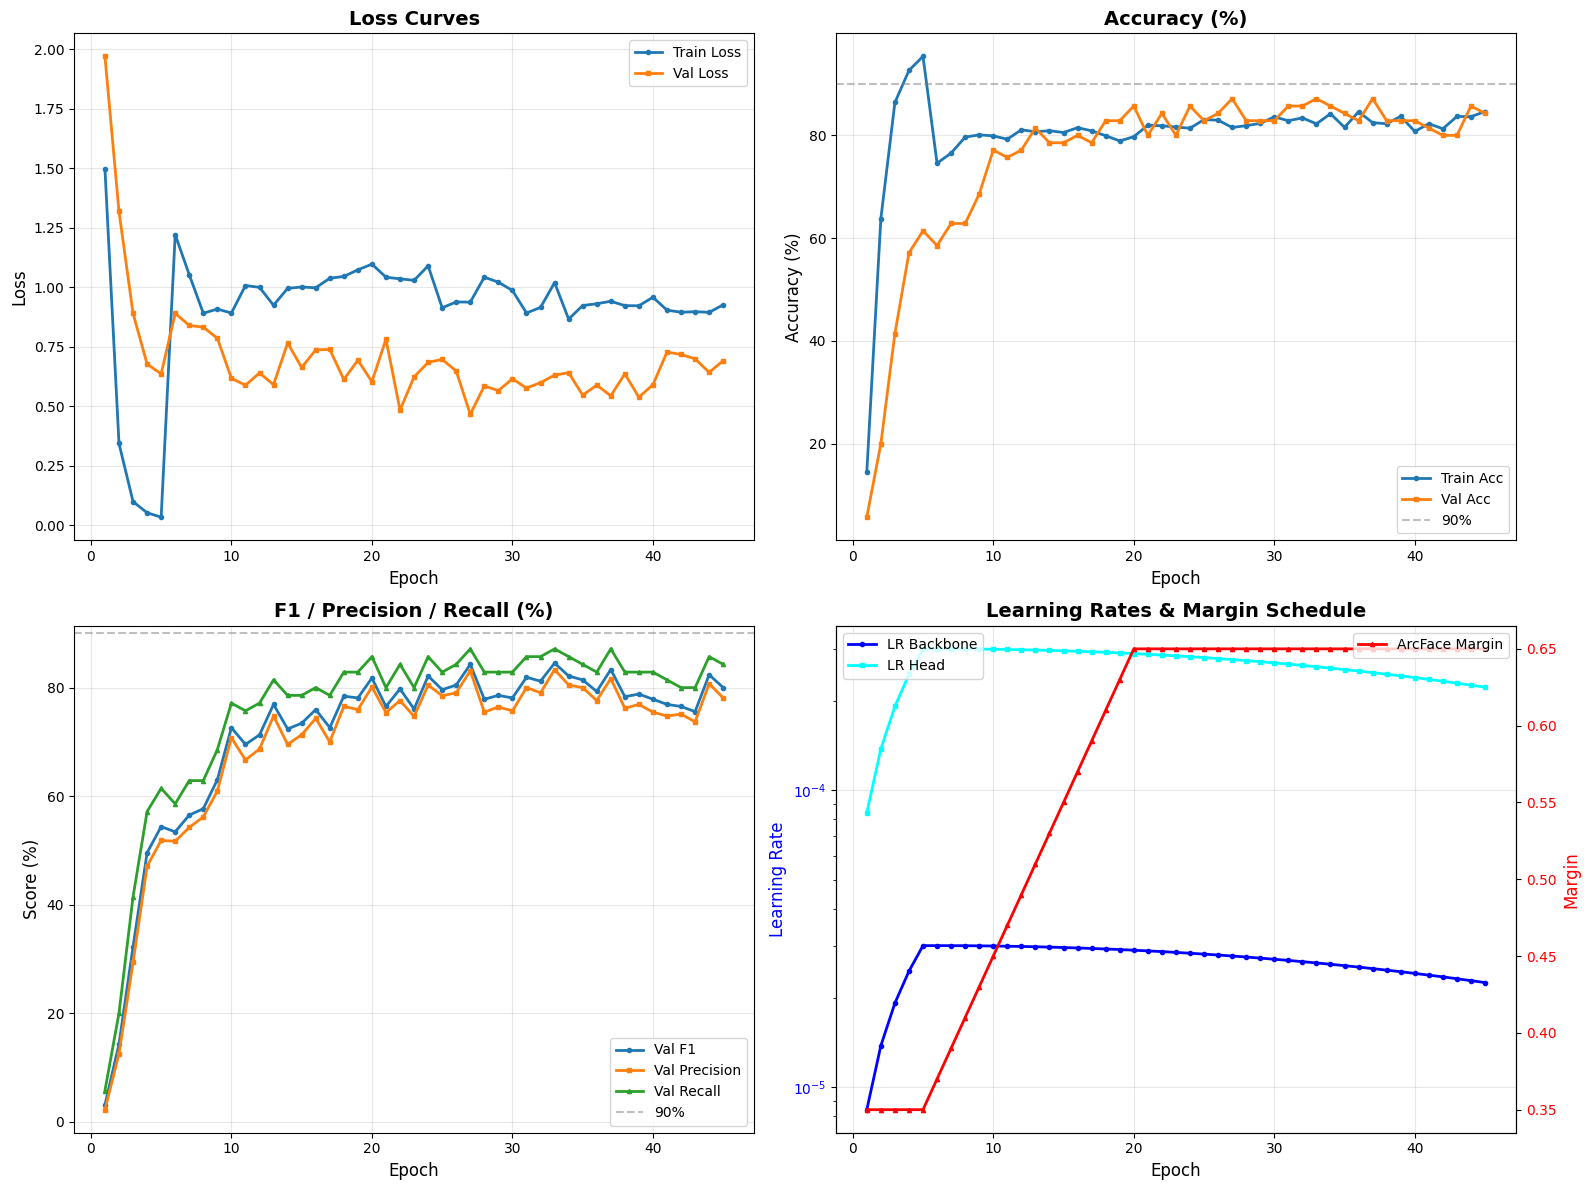

In [16]:
df_metrics = pd.read_csv(METRIC_CSV)

epochs_plot = df_metrics["epoch"]
train_loss = df_metrics["train_loss"].astype(float)
val_loss = df_metrics["val_loss"].astype(float)
train_acc = df_metrics["train_acc"].astype(float) * 100
val_acc = df_metrics["val_acc"].astype(float) * 100
val_f1 = df_metrics["val_f1"].astype(float) * 100
val_prec = df_metrics["val_prec"].astype(float) * 100
val_rec = df_metrics["val_rec"].astype(float) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss
axes[0, 0].plot(epochs_plot, train_loss, label="Train Loss", marker="o", markersize=3, linewidth=2)
axes[0, 0].plot(epochs_plot, val_loss, label="Val Loss", marker="s", markersize=3, linewidth=2)
axes[0, 0].set_title("Loss Curves", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Epoch", fontsize=12)
axes[0, 0].set_ylabel("Loss", fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=10)

# Plot 2: Accuracy
axes[0, 1].plot(epochs_plot, train_acc, label="Train Acc", marker="o", markersize=3, linewidth=2)
axes[0, 1].plot(epochs_plot, val_acc, label="Val Acc", marker="s", markersize=3, linewidth=2)
axes[0, 1].axhline(90, linestyle="--", color="gray", alpha=0.5, label="90%")
axes[0, 1].set_title("Accuracy (%)", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Epoch", fontsize=12)
axes[0, 1].set_ylabel("Accuracy (%)", fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=10)

# Plot 3: F1, Precision, Recall
axes[1, 0].plot(epochs_plot, val_f1, label="Val F1", marker="o", markersize=3, linewidth=2)
axes[1, 0].plot(epochs_plot, val_prec, label="Val Precision", marker="s", markersize=3, linewidth=2)
axes[1, 0].plot(epochs_plot, val_rec, label="Val Recall", marker="^", markersize=3, linewidth=2)
axes[1, 0].axhline(90, linestyle="--", color="gray", alpha=0.5, label="90%")
axes[1, 0].set_title("F1 / Precision / Recall (%)", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Epoch", fontsize=12)
axes[1, 0].set_ylabel("Score (%)", fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=10)

# Plot 4: Learning Rates & Margin
ax1 = axes[1, 1]
ax2 = ax1.twinx()

lr_backbone_plot = df_metrics["lr_backbone"].astype(float)
lr_head_plot = df_metrics["lr_head"].astype(float)
margin_plot = df_metrics["margin"].astype(float)

ax1.plot(epochs_plot, lr_backbone_plot, label="LR Backbone", marker="o", markersize=3, linewidth=2, color='blue')
ax1.plot(epochs_plot, lr_head_plot, label="LR Head", marker="s", markersize=3, linewidth=2, color='cyan')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Learning Rate", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=10)

ax2.plot(epochs_plot, margin_plot, label="ArcFace Margin", marker="^", markersize=3, linewidth=2, color='red')
ax2.set_ylabel("Margin", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right', fontsize=10)

axes[1, 1].set_title("Learning Rates & Margin Schedule", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=150, bbox_inches="tight")
plt.show()


In [17]:

print(" FINAL SUMMARY")

df_final = df_metrics.iloc[-1]
print(f"Final Epoch: {int(df_final['epoch'])}")
print(f"Final Train Acc: {df_final['train_acc']*100:.2f}%")
print(f"Final Val Acc: {df_final['val_acc']*100:.2f}%")
print(f"Final Val F1: {df_final['val_f1']*100:.2f}%")
print(f"Final Val Precision: {df_final['val_prec']*100:.2f}%")
print(f"Final Val Recall: {df_final['val_rec']*100:.2f}%")
print()
print(f" Best Val Acc: {val_acc.max()*100:.2f}%")
print(f" Best Val F1: {best_f1*100:.2f}%")
print(f" Best Val Precision: {val_prec.max():.2f}%")
print(f" Best Val Recall: {val_rec.max():.2f}%")


 FINAL SUMMARY
Final Epoch: 45
Final Train Acc: 84.64%
Final Val Acc: 84.29%
Final Val F1: 80.00%
Final Val Precision: 78.10%
Final Val Recall: 84.29%

 Best Val Acc: 8714.29%
 Best Val F1: 84.52%
 Best Val Precision: 83.33%
 Best Val Recall: 87.14%
